<a href="https://colab.research.google.com/github/danon6868/BI-ml-2024/blob/main/lecture_workshop_nematodes/nematods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install loguru

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 3.3 MB/s eta 0:00:00


In [ ]:
import pickle
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import os
import seaborn as sns

from os.path import join
from loguru import logger
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch import nn
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, f1_score

from sklearn.metrics import classification_report
import pandas as pd

In [ ]:
DATA_PATH = "/content/drive/MyDrive/teaching/BI_2022_ML/lecture_12_workshop/I-Nema/"
RESCALE_SIZE = 224, 224
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32

print(f"Using device: {DEVICE}")

Using device: cuda


## Напишем класс `NematodDataset`

Рассказывали ли про `pathlib`?

In [ ]:
class NematodDataset(Dataset):
    def __init__(self, files, mode="train") -> None:
        super().__init__()

        self.files = sorted(list(files))
        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()
        self.mode = mode

        self.labels = [path.parent.name for path in self.files]
        self.label_encoder.fit(self.labels)

        if self.mode == "train":
            with open("label_encoder.pkl", "wb") as le_dump_file:
                    pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        if self.mode == "train":
            transform = transforms.Compose([
                        transforms.Resize(size=RESCALE_SIZE),
                        transforms.RandomRotation(degrees=180),
                        # ADDITIONAL AUGMENTATIONS
                        transforms.ToTensor(),
                        #transforms.Normalize([0.572], [0.048])
            ])

        else:
            transform = transforms.Compose([
                        transforms.Resize(size=RESCALE_SIZE),
                        transforms.ToTensor(),
                        #transforms.Normalize([0.572], [0.048])
            ])

        x = self.load_sample(self.files[index])
        x = transform(x)
        if x.shape[0] != 1:
            x = x[:3, :, :].mean(dim=0).view(1, *RESCALE_SIZE)

        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()

        return x, y

Оказывается, что не все изображения имеют 1 канал...

In [ ]:
# for i in tqdm(trainset):
#     if i[0].shape != torch.Size([1, 224, 224]):
#         print(i[0].shape)

  0%|          | 0/2019 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
 57%|█████▋    | 1142/2019 [09:41<07:43,  1.89it/s]

torch.Size([4, 224, 224])


 57%|█████▋    | 1143/2019 [09:41<07:48,  1.87it/s]

torch.Size([4, 224, 224])


 57%|█████▋    | 1154/2019 [09:47<07:35,  1.90it/s]

torch.Size([4, 224, 224])


 82%|████████▏ | 1658/2019 [14:16<07:21,  1.22s/it]

torch.Size([3, 224, 224])


 82%|████████▏ | 1659/2019 [14:17<06:28,  1.08s/it]

torch.Size([3, 224, 224])


 82%|████████▏ | 1660/2019 [14:18<05:33,  1.08it/s]

torch.Size([3, 224, 224])


 82%|████████▏ | 1661/2019 [14:18<05:16,  1.13it/s]

torch.Size([3, 224, 224])


 82%|████████▏ | 1662/2019 [14:19<04:40,  1.27it/s]

torch.Size([3, 224, 224])


 82%|████████▏ | 1663/2019 [14:20<04:38,  1.28it/s]

torch.Size([3, 224, 224])


 82%|████████▏ | 1665/2019 [14:22<05:14,  1.13it/s]

torch.Size([3, 224, 224])


 84%|████████▍ | 1694/2019 [14:38<03:53,  1.39it/s]

torch.Size([3, 224, 224])


 84%|████████▍ | 1695/2019 [14:39<04:24,  1.23it/s]

torch.Size([3, 224, 224])


 84%|████████▍ | 1696/2019 [14:40<04:40,  1.15it/s]

torch.Size([3, 224, 224])


 84%|████████▍ | 1697/2019 [14:41<04:08,  1.30it/s]

torch.Size([3, 224, 224])


 87%|████████▋ | 1761/2019 [15:14<02:32,  1.69it/s]

torch.Size([4, 224, 224])


 87%|████████▋ | 1762/2019 [15:15<03:07,  1.37it/s]

torch.Size([4, 224, 224])


 87%|████████▋ | 1763/2019 [15:16<02:52,  1.49it/s]

torch.Size([4, 224, 224])


 87%|████████▋ | 1764/2019 [15:16<02:41,  1.58it/s]

torch.Size([4, 224, 224])


 87%|████████▋ | 1765/2019 [15:17<03:13,  1.31it/s]

torch.Size([4, 224, 224])


 87%|████████▋ | 1766/2019 [15:18<03:03,  1.38it/s]

torch.Size([4, 224, 224])


 90%|████████▉ | 1808/2019 [15:49<03:01,  1.16it/s]

torch.Size([4, 224, 224])


 90%|████████▉ | 1809/2019 [15:49<02:36,  1.34it/s]

torch.Size([4, 224, 224])


 90%|████████▉ | 1810/2019 [15:50<02:38,  1.32it/s]

torch.Size([4, 224, 224])


 90%|████████▉ | 1811/2019 [15:51<02:22,  1.46it/s]

torch.Size([4, 224, 224])


 90%|████████▉ | 1812/2019 [15:51<02:28,  1.40it/s]

torch.Size([4, 224, 224])


 90%|████████▉ | 1813/2019 [15:52<02:16,  1.51it/s]

torch.Size([4, 224, 224])


 90%|████████▉ | 1814/2019 [15:53<02:20,  1.46it/s]

torch.Size([4, 224, 224])


 90%|████████▉ | 1815/2019 [15:53<02:09,  1.58it/s]

torch.Size([4, 224, 224])


 90%|████████▉ | 1816/2019 [15:54<02:11,  1.54it/s]

torch.Size([4, 224, 224])


 90%|████████▉ | 1817/2019 [15:54<02:05,  1.61it/s]

torch.Size([4, 224, 224])


 90%|█████████ | 1819/2019 [15:58<03:37,  1.09s/it]

torch.Size([4, 224, 224])


 90%|█████████ | 1820/2019 [15:58<03:06,  1.07it/s]

torch.Size([4, 224, 224])


 90%|█████████ | 1821/2019 [15:59<02:40,  1.23it/s]

torch.Size([4, 224, 224])


 90%|█████████ | 1822/2019 [16:00<02:25,  1.35it/s]

torch.Size([4, 224, 224])


 90%|█████████ | 1823/2019 [16:00<02:15,  1.44it/s]

torch.Size([4, 224, 224])


 90%|█████████ | 1824/2019 [16:01<02:06,  1.54it/s]

torch.Size([4, 224, 224])


 90%|█████████ | 1825/2019 [16:01<02:06,  1.54it/s]

torch.Size([4, 224, 224])


 92%|█████████▏| 1862/2019 [16:22<02:49,  1.08s/it]

torch.Size([3, 224, 224])


 92%|█████████▏| 1863/2019 [16:25<04:07,  1.59s/it]

torch.Size([3, 224, 224])


 92%|█████████▏| 1864/2019 [16:27<03:58,  1.54s/it]

torch.Size([3, 224, 224])


 92%|█████████▏| 1865/2019 [16:28<03:45,  1.46s/it]

torch.Size([3, 224, 224])


 92%|█████████▏| 1866/2019 [16:29<03:30,  1.38s/it]

torch.Size([3, 224, 224])


 92%|█████████▏| 1867/2019 [16:30<03:12,  1.27s/it]

torch.Size([3, 224, 224])


 93%|█████████▎| 1870/2019 [16:33<02:35,  1.04s/it]

torch.Size([4, 224, 224])


 93%|█████████▎| 1871/2019 [16:33<02:12,  1.11it/s]

torch.Size([4, 224, 224])


 93%|█████████▎| 1872/2019 [16:34<02:06,  1.16it/s]

torch.Size([4, 224, 224])


 93%|█████████▎| 1873/2019 [16:35<01:53,  1.28it/s]

torch.Size([4, 224, 224])


 93%|█████████▎| 1874/2019 [16:35<01:42,  1.41it/s]

torch.Size([4, 224, 224])


 93%|█████████▎| 1875/2019 [16:36<01:35,  1.50it/s]

torch.Size([4, 224, 224])


 93%|█████████▎| 1876/2019 [16:36<01:31,  1.57it/s]

torch.Size([4, 224, 224])


 93%|█████████▎| 1877/2019 [16:37<01:28,  1.61it/s]

torch.Size([4, 224, 224])


 93%|█████████▎| 1878/2019 [16:38<01:29,  1.57it/s]

torch.Size([4, 224, 224])


 93%|█████████▎| 1879/2019 [16:38<01:34,  1.49it/s]

torch.Size([4, 224, 224])


 93%|█████████▎| 1880/2019 [16:39<01:31,  1.53it/s]

torch.Size([4, 224, 224])


 93%|█████████▎| 1881/2019 [16:40<01:28,  1.55it/s]

torch.Size([4, 224, 224])


 93%|█████████▎| 1882/2019 [16:40<01:25,  1.60it/s]

torch.Size([4, 224, 224])


 93%|█████████▎| 1885/2019 [16:42<01:15,  1.78it/s]

torch.Size([4, 224, 224])


 93%|█████████▎| 1886/2019 [16:42<01:14,  1.79it/s]

torch.Size([4, 224, 224])


 93%|█████████▎| 1887/2019 [16:43<01:12,  1.82it/s]

torch.Size([4, 224, 224])


 94%|█████████▎| 1888/2019 [16:43<01:11,  1.84it/s]

torch.Size([4, 224, 224])


 94%|█████████▎| 1889/2019 [16:44<01:09,  1.87it/s]

torch.Size([4, 224, 224])


 94%|█████████▎| 1890/2019 [16:44<01:08,  1.88it/s]

torch.Size([4, 224, 224])


 94%|█████████▎| 1891/2019 [16:45<01:07,  1.89it/s]

torch.Size([4, 224, 224])


 94%|█████████▎| 1892/2019 [16:45<01:07,  1.87it/s]

torch.Size([4, 224, 224])


 94%|█████████▍| 1893/2019 [16:46<01:12,  1.74it/s]

torch.Size([4, 224, 224])


 94%|█████████▍| 1894/2019 [16:47<01:13,  1.70it/s]

torch.Size([4, 224, 224])


 94%|█████████▍| 1895/2019 [16:47<01:12,  1.70it/s]

torch.Size([4, 224, 224])


 94%|█████████▍| 1896/2019 [16:48<01:12,  1.69it/s]

torch.Size([4, 224, 224])


 94%|█████████▍| 1897/2019 [16:48<01:13,  1.67it/s]

torch.Size([4, 224, 224])


 94%|█████████▍| 1898/2019 [16:49<01:14,  1.62it/s]

torch.Size([4, 224, 224])


 94%|█████████▍| 1899/2019 [16:50<01:28,  1.35it/s]

torch.Size([3, 224, 224])


 94%|█████████▍| 1900/2019 [16:51<01:38,  1.21it/s]

torch.Size([3, 224, 224])


 94%|█████████▍| 1901/2019 [16:52<01:32,  1.27it/s]

torch.Size([3, 224, 224])


 94%|█████████▍| 1906/2019 [16:54<01:03,  1.79it/s]

torch.Size([4, 224, 224])


 94%|█████████▍| 1907/2019 [16:55<01:00,  1.86it/s]

torch.Size([4, 224, 224])


 95%|█████████▍| 1908/2019 [16:55<00:57,  1.92it/s]

torch.Size([4, 224, 224])


 95%|█████████▍| 1909/2019 [16:56<00:57,  1.90it/s]

torch.Size([3, 224, 224])


 95%|█████████▍| 1910/2019 [16:57<01:16,  1.42it/s]

torch.Size([3, 224, 224])


 95%|█████████▍| 1911/2019 [16:58<01:28,  1.22it/s]

torch.Size([3, 224, 224])


 95%|█████████▍| 1912/2019 [16:59<01:35,  1.12it/s]

torch.Size([3, 224, 224])


 95%|█████████▍| 1913/2019 [17:00<01:24,  1.25it/s]

torch.Size([4, 224, 224])


 95%|█████████▍| 1914/2019 [17:00<01:14,  1.41it/s]

torch.Size([4, 224, 224])


 95%|█████████▍| 1915/2019 [17:01<01:24,  1.23it/s]

torch.Size([3, 224, 224])


 95%|█████████▍| 1916/2019 [17:02<01:16,  1.34it/s]

torch.Size([4, 224, 224])


 95%|█████████▍| 1917/2019 [17:03<01:16,  1.33it/s]

torch.Size([4, 224, 224])


 95%|█████████▍| 1918/2019 [17:04<01:28,  1.14it/s]

torch.Size([3, 224, 224])


 95%|█████████▌| 1919/2019 [17:04<01:16,  1.31it/s]

torch.Size([4, 224, 224])


 95%|█████████▌| 1920/2019 [17:05<01:24,  1.17it/s]

torch.Size([3, 224, 224])


 95%|█████████▌| 1921/2019 [17:06<01:12,  1.34it/s]

torch.Size([4, 224, 224])


 95%|█████████▌| 1922/2019 [17:07<01:20,  1.21it/s]

torch.Size([3, 224, 224])


 95%|█████████▌| 1923/2019 [17:07<01:10,  1.37it/s]

torch.Size([4, 224, 224])


 95%|█████████▌| 1924/2019 [17:08<01:03,  1.50it/s]

torch.Size([4, 224, 224])


 95%|█████████▌| 1925/2019 [17:08<00:57,  1.63it/s]

torch.Size([4, 224, 224])


 99%|█████████▉| 1997/2019 [17:52<00:12,  1.74it/s]

torch.Size([4, 224, 224])


 99%|█████████▉| 1998/2019 [17:53<00:12,  1.73it/s]

torch.Size([4, 224, 224])


 99%|█████████▉| 1999/2019 [17:54<00:14,  1.42it/s]

torch.Size([4, 224, 224])


 99%|█████████▉| 2000/2019 [17:54<00:12,  1.53it/s]

torch.Size([4, 224, 224])


 99%|█████████▉| 2001/2019 [17:55<00:11,  1.59it/s]

torch.Size([4, 224, 224])


 99%|█████████▉| 2002/2019 [17:56<00:10,  1.60it/s]

torch.Size([4, 224, 224])


 99%|█████████▉| 2003/2019 [17:57<00:11,  1.35it/s]

torch.Size([4, 224, 224])


 99%|█████████▉| 2004/2019 [17:58<00:12,  1.19it/s]

torch.Size([4, 224, 224])


 99%|█████████▉| 2005/2019 [17:58<00:10,  1.29it/s]

torch.Size([4, 224, 224])


 99%|█████████▉| 2006/2019 [17:59<00:11,  1.18it/s]

torch.Size([4, 224, 224])


 99%|█████████▉| 2007/2019 [18:00<00:09,  1.32it/s]

torch.Size([4, 224, 224])


 99%|█████████▉| 2008/2019 [18:00<00:07,  1.46it/s]

torch.Size([4, 224, 224])


100%|█████████▉| 2009/2019 [18:01<00:06,  1.55it/s]

torch.Size([4, 224, 224])


100%|█████████▉| 2010/2019 [18:01<00:05,  1.64it/s]

torch.Size([4, 224, 224])


100%|█████████▉| 2011/2019 [18:02<00:04,  1.69it/s]

torch.Size([4, 224, 224])


100%|█████████▉| 2012/2019 [18:02<00:03,  1.77it/s]

torch.Size([4, 224, 224])


100%|█████████▉| 2013/2019 [18:03<00:03,  1.74it/s]

torch.Size([4, 224, 224])


100%|█████████▉| 2014/2019 [18:04<00:02,  1.81it/s]

torch.Size([4, 224, 224])


100%|█████████▉| 2015/2019 [18:04<00:02,  1.85it/s]

torch.Size([4, 224, 224])


100%|█████████▉| 2016/2019 [18:05<00:01,  1.82it/s]

torch.Size([4, 224, 224])


100%|█████████▉| 2017/2019 [18:05<00:01,  1.84it/s]

torch.Size([4, 224, 224])


100%|█████████▉| 2018/2019 [18:06<00:00,  1.88it/s]

torch.Size([4, 224, 224])


100%|██████████| 2019/2019 [18:06<00:00,  1.86it/s]

torch.Size([4, 224, 224])


Исправить это можно двумя пуятми: просто убрать эти картинки или усреднять по первым трем каналам изображение, делая из него одноканальное. Реализуем второй вариант в `__getitem__`

## Класс для тренировки и валидации модели

In [ ]:
class Trainer:
    def __init__(self, model, epochs, criterion,
                 optimizer, trainloader,
                 validloader, device, metric,
                 validate=True, scheduler=None,
                 verbose=2):
        self.model = model.to(device)
        self.epochs = epochs
        self.criterion = criterion
        self.optimizer = optimizer
        self.trainloader = trainloader
        self.validloader = validloader
        self.device = device
        self.metric = metric
        self.validate = validate
        self.verbose = verbose
        self.scheduler = scheduler
        self.get_probs = nn.Softmax(dim=0)
        self.train_losses = []
        self.valid_losses = []
        self.train_metrics = []
        self.valid_metrics = []

    def fit(self, epochs=None):
        if epochs is None:
            epochs = self.epochs

        for epoch in range(epochs):
            train_loss, train_metric = self._train(self.trainloader)
            self.train_losses.append(train_loss)
            self.train_metrics.append(train_metric)

            if self.validate:
                val_loss, val_metric = self._validate(self.validloader)
                self.valid_losses.append(val_loss)
                self.valid_metrics.append(val_metric)

                if self.scheduler is not None:
                    self.scheduler.step(val_loss)
            else:
                val_loss = "NO"

            if self.verbose > 0:
                print()
                print(f"Epoch {epoch+1} out of {epochs}: Train loss = {train_loss}, validation loss = {val_loss} \n\
                                         Train metric = {train_metric}, validation metric = {val_metric}")
                print()

        return self

    def _train(self, loader):
        self.model.train()
        epoch_loss = 0
        epoch_preds = []
        epoch_targets = []
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            out = self.model(inputs)
            loss = self.criterion(out, targets)
            epoch_loss += loss.item()
            self.optimizer.zero_grad()
            loss.backward()

            if self.verbose > 1:
                print(f"\rTraining: batch {i+1} out of {len(loader)}", end="")

            self.optimizer.step()

            out = self.get_probs(out)
            _, preds = torch.max(out.data, 1)
            epoch_preds += list(preds.cpu())
            epoch_targets += list(targets.detach().cpu())

            self._clear_vram(inputs, targets, out)

        epoch_loss = epoch_loss/len(loader)
        epoch_metric = self.metric(epoch_targets, epoch_preds)
        print("\n", end="")

        return epoch_loss, epoch_metric

    def _validate(self, loader):
        self.model.eval()
        epoch_loss = 0
        epoch_preds = []
        epoch_targets = []
        with torch.no_grad():
            for i, (inputs, targets) in enumerate(loader):
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                out = self.model(inputs)
                loss = self.criterion(out, targets)

                if self.verbose > 1:
                    print(f"\rValidation: batch {i+1} out of {len(loader)}", end="")

                epoch_loss += loss.item()
                out = self.get_probs(out)
                _, preds = torch.max(out.data, 1)
                epoch_preds += list(preds.cpu())
                epoch_targets += list(targets.detach().cpu())

                self._clear_vram(inputs, targets, out)

        epoch_loss = epoch_loss/len(loader)
        epoch_metric = self.metric(epoch_targets, epoch_preds)
        print("\n", end="")

        return epoch_loss, epoch_metric

    def _clear_vram(self, inputs, labels, outputs):
        inputs = inputs.to("cpu")
        labels = labels.to("cpu")
        outputs = outputs.to("cpu")
        del inputs, labels, outputs
        torch.cuda.empty_cache()

In [ ]:
def predict(model, loader):
    model.eval()
    predictions = []
    targ = []
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            out = model(inputs)
            out = nn.functional.softmax(out, dim=-1)
            _, preds = torch.max(out.data, 1)
            predictions += list(preds)
            targ += list(targets)

    return predictions, targ

def calculate_metric(model, loader, metric=None):
    if metric is None:
        metric = accuracy_score

    preds, targets = predict(model, loader)
    preds = [i.item() for i in preds]
    targets = [i.item() for i in targets]

    return metric(targets, preds)

Эта часть кода нужна лишь для того, чтобы из tiff сделать jpeg. Иначе в процессе получения батчей иногда возникали странные ошибки.

In [ ]:
# train_val_files = sorted(list(Path(DATA_PATH).rglob("*.tif")))

In [ ]:
# for infile in tqdm(train_val_files):
#     if infile.name[-3:] == "tif":
#         outfile = Path(str(infile.parent) + "/" + infile.name[:-3]+"jpg")
#         im = Image.open(infile)
#         out = im.convert("RGB")
#         out.save(outfile, "JPEG", quality=100)
#         os.remove(infile)

100%|██████████| 2692/2692 [25:06<00:00,  1.79it/s]


Получем список всех файлов. Создаем для каждого метку класса и делим на тренировку и валидацию.

In [ ]:
train_val_files = sorted(list(Path(DATA_PATH).rglob("*.jpg")))
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)
N_CLASSES = len(set(train_val_labels))
N_CLASSES

19

In [ ]:
train_val_files[0].parent.name

'Acrobeles'

Важно посмотреть на распределение классов. Если оно у нас будет несбалансированным, то может быть, хорошей идеей поработать с этим (например, тот же upsampling редко представленных классов):

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


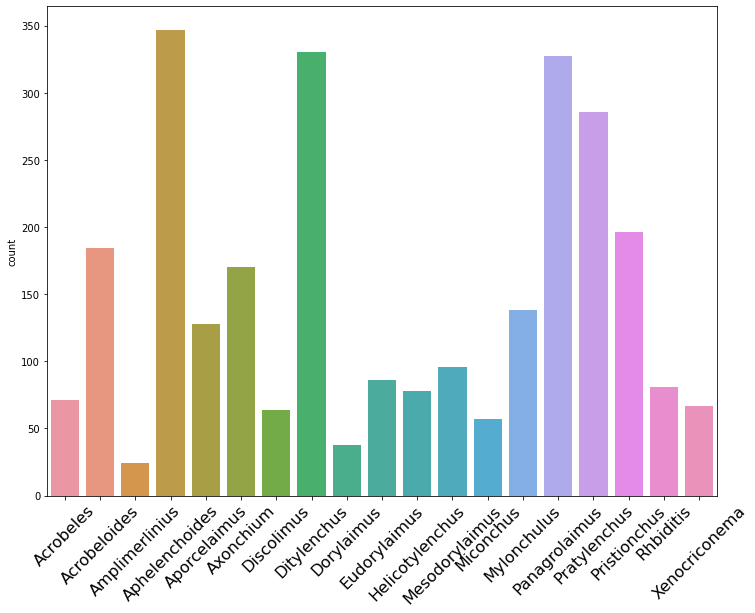

In [ ]:
plt.figure(figsize=(12, 9))
sns.countplot(train_val_labels)
plt.xticks(rotation=45, fontsize=16);

Создаем датасеты и даталоадеры.

In [ ]:
trainset = NematodDataset(train_files)
valset = NematodDataset(val_files, mode="val")

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False)

Возьмем какую-то готовую модель, например, `VGG19` с батч-нормализацией:

In [ ]:
model = torchvision.models.vgg19_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_6.png"  width="400" rotate="180"></center>
<center><em>Сравнение архитектур сетей AlexNet, VGG16 (использует 16 слоев) и VGG19 (использует 19 слоев).</em></center>

На выходе у модели 1000 классов, а у нас 19. Мы уже знаем, как это изменить. Просто поменяем аттрибут `model.classifier` на линейный слой с нужным числов выходов (можно на несколько линейных слоев, помещенных в `nn.Sequential`).

Но возникает проблема поинтереснее: на входе модель ожидает картинку с 3 каналами, а у нас 1. Один из вариантов (он не самый хороший) это просто поменять первый сверточный слой в модели и обучать ее целиком (**подумайте**, почему мы не можем заморозить все слои кроме новых и обучать так модель?).

In [ ]:
num_features = 25088
model.classifier = nn.Linear(num_features, N_CLASSES)
model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model = model.to(DEVICE)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
trainer = Trainer(model, 10, criterion, optimizer, trainloader, valloader, DEVICE, accuracy_score)
trainer.fit()

Training: batch 65 out of 65
Validation: batch 22 out of 22

Epoch 1 out of 10: Train loss = 2.4838037747603194, validation loss = 2.331028781153939 
                                         Train metric = 0.2138728323699422, validation metric = 0.24566473988439305

Training: batch 65 out of 65
Validation: batch 22 out of 22

Epoch 2 out of 10: Train loss = 2.1527602232419527, validation loss = 2.0934535373340952 
                                         Train metric = 0.2923892100192678, validation metric = 0.2861271676300578

Training: batch 65 out of 65
Validation: batch 22 out of 22

Epoch 3 out of 10: Train loss = 1.922408839372488, validation loss = 2.088286367329684 
                                         Train metric = 0.3492292870905588, validation metric = 0.3208092485549133

Training: batch 65 out of 65
Validation: batch 22 out of 22

Epoch 4 out of 10: Train loss = 1.7319608211517334, validation loss = 1.8847060907970776 
                                         Train met

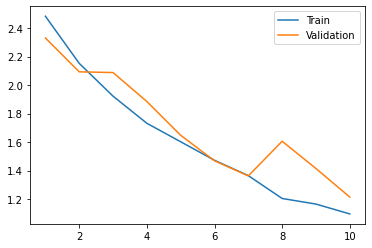

In [ ]:
sns.lineplot(y=trainer.train_losses, x=range(1, 11), label="Train")
sns.lineplot(y=trainer.valid_losses, x=range(1, 11), label="Validation")

plt.show()

In [ ]:
calculate_metric(model, valloader)

0.5867052023121387

In [ ]:
from functools import partial

f1_macro = partial(f1_score, average="macro")
f1_micro = partial(f1_score, average="micro")

In [ ]:
calculate_metric(model, valloader, f1_macro)

0.478493800691597

In [ ]:
calculate_metric(model, valloader, f1_micro)

0.5751445086705202

## Изменение скорости обучения в процессе

Понятное дело, что наш `lr` может как-то меняться в процессе (он и так меняется при использовании определенных оптимизаторов), например, в начале он может быть повыше и снижаться по мере приближения к минимуму. Для контроля этого в процессе обучения в `PyTorch` есть следующий модуль:  

In [ ]:
torch.optim.lr_scheduler

<module 'torch.optim.lr_scheduler' from '/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py'>

Там есть много всего, мы рассмотрим один:

In [ ]:
torch.optim.lr_scheduler.ReduceLROnPlateau

torch.optim.lr_scheduler.ReduceLROnPlateau

На вход он принимает наш оптимизатор. И если лосс на валидации не будет уменьшаться `patience` число эпох, то скорость обучения умножится на заданную константу, которая меньше 1.

## Протестируем на `AlexNet`

Размер входных картинок в данном случае должен быть 256х256!

In [ ]:
RESCALE_SIZE = 256, 256

trainset = NematodDataset(train_files)
valset = NematodDataset(val_files, mode="val")

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model = torchvision.models.alexnet(pretrained=True)

In [ ]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
num_features = 9216
model.classifier = nn.Linear(num_features, N_CLASSES)
model.features[0] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=3, factor=0.5)

In [ ]:
model_trainer = Trainer(model, 5, criterion, optimizer, trainloader, valloader, DEVICE, accuracy_score, scheduler=scheduler)
model_trainer.fit()

Training: batch 33 out of 33
Validation: batch 11 out of 11

Epoch 1 out of 5: Train loss = 2.6975488734967783, validation loss = 2.6593444130637427 
                                         Train metric = 0.08863198458574181, validation metric = 0.12138728323699421

Training: batch 33 out of 33
Validation: batch 11 out of 11

Epoch 2 out of 5: Train loss = 2.555759466055668, validation loss = 2.427523959766735 
                                         Train metric = 0.14402697495183045, validation metric = 0.16618497109826588

Training: batch 33 out of 33
Validation: batch 11 out of 11

Epoch 3 out of 5: Train loss = 2.4508047970858486, validation loss = 2.390777999704534 
                                         Train metric = 0.18545279383429672, validation metric = 0.1907514450867052

Training: batch 33 out of 33
Validation: batch 11 out of 11

Epoch 4 out of 5: Train loss = 2.3886798656348027, validation loss = 2.3853555592623623 
                                         Train met

## VGG19

In [ ]:
model = torchvision.models.vgg19_bn(pretrained=True)

num_features = 25088
model.classifier = nn.Linear(num_features, N_CLASSES)
model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=3, factor=0.5)

In [ ]:
model_trainer = Trainer(model, 5, criterion, optimizer, trainloader, valloader, DEVICE, accuracy_score, scheduler=scheduler)
model_trainer.fit()

Training: batch 42 out of 42
Validation: batch 14 out of 14

Epoch 1 out of 5: Train loss = 2.4790037898790267, validation loss = 2.2360584565571378 
                                         Train metric = 0.20423892100192678, validation metric = 0.24277456647398843

Training: batch 42 out of 42
Validation: batch 14 out of 14

Epoch 2 out of 5: Train loss = 2.038113369828179, validation loss = 1.970150147165571 
                                         Train metric = 0.31647398843930635, validation metric = 0.33236994219653176

Training: batch 42 out of 42
Validation: batch 14 out of 14

Epoch 3 out of 5: Train loss = 1.7901459733645122, validation loss = 1.8030682291303362 
                                         Train metric = 0.3737957610789981, validation metric = 0.3945086705202312

Training: batch 42 out of 42
Validation: batch 14 out of 14

Epoch 4 out of 5: Train loss = 1.5801141262054443, validation loss = 1.609710259096963 
                                         Train metr

In [ ]:
model = torchvision.models.vgg19_bn(pretrained=False)

num_features = 25088
model.classifier = nn.Linear(num_features, N_CLASSES)
model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=3, factor=0.5)

model_trainer = Trainer(model, 15, criterion, optimizer, trainloader, valloader, DEVICE, accuracy_score, scheduler=scheduler)
model_trainer.fit()

Training: batch 42 out of 42
Validation: batch 14 out of 14

Epoch 1 out of 15: Train loss = 3.2210415374665033, validation loss = 2.8139758620943343 
                                         Train metric = 0.0804431599229287, validation metric = 0.13583815028901733

Training: batch 42 out of 42
Validation: batch 14 out of 14

Epoch 2 out of 15: Train loss = 2.6183821076438543, validation loss = 2.4352615560804094 
                                         Train metric = 0.1315028901734104, validation metric = 0.20664739884393063

Training: batch 42 out of 42
Validation: batch 14 out of 14

Epoch 3 out of 15: Train loss = 2.5029581614903043, validation loss = 2.4126152651650563 
                                         Train metric = 0.17822736030828518, validation metric = 0.21676300578034682

Training: batch 42 out of 42
Validation: batch 14 out of 14

Epoch 4 out of 15: Train loss = 2.4659127451124645, validation loss = 2.354813780103411 
                                         Trai

KeyboardInterrupt: ignored

## ResNet

In [ ]:
RESCALE_SIZE = 224, 224

In [ ]:
trainset = NematodDataset(train_files)
valset = NematodDataset(val_files, mode="val")

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model = torchvision.models.resnet152(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [ ]:
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(in_features=2048, out_features=N_CLASSES, bias=True)
model = model.to(DEVICE)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=3, factor=0.5)

model_trainer = Trainer(model, 15, criterion, optimizer, trainloader, valloader, DEVICE, accuracy_score, scheduler=scheduler)
model_trainer.fit()

Training: batch 65 out of 65
Validation: batch 22 out of 22

Epoch 1 out of 15: Train loss = 2.3878689069014327, validation loss = 2.3580352555621755 
                                         Train metric = 0.197495183044316, validation metric = 0.10838150289017341

Training: batch 65 out of 65
Validation: batch 22 out of 22

Epoch 2 out of 15: Train loss = 1.983774993969844, validation loss = 1.9948351789604535 
                                         Train metric = 0.3010597302504817, validation metric = 0.12572254335260116

Training: batch 65 out of 65
Validation: batch 22 out of 22

Epoch 3 out of 15: Train loss = 1.7561423833553607, validation loss = 2.193022142757069 
                                         Train metric = 0.3559730250481696, validation metric = 0.12861271676300579

Training: batch 65 out of 65
Validation: batch 22 out of 22

Epoch 4 out of 15: Train loss = 1.5533293063823994, validation loss = 1.686485466631976 
                                         Train me

KeyboardInterrupt: ignored

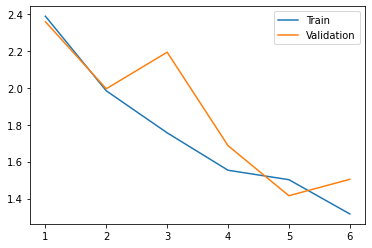

In [ ]:
sns.lineplot(y=model_trainer.train_losses, x=range(1, 7), label="Train")
sns.lineplot(y=model_trainer.valid_losses, x=range(1, 7), label="Validation")

plt.show()

Можно добавить больше аугментаций, подобрать скорость обучения и учить побольше эпох (в целом можно и выбрать другую архитектуру). Но пока что остановимся на этом. Нужно проверить, на каких объектах ошибается модель. Если это объекты редко представленных классов, то может быть полезно применить методы борьбы с дисбалансом классов.

## Посмотрим на предсказания модели

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()

    return probs


def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp.reshape(*RESCALE_SIZE), cmap="gray")
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)


def get_predicts(model, test_loader):
    with torch.no_grad():
        logits = []
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()

    return probs

In [ ]:
label_encoder = trainset.label_encoder

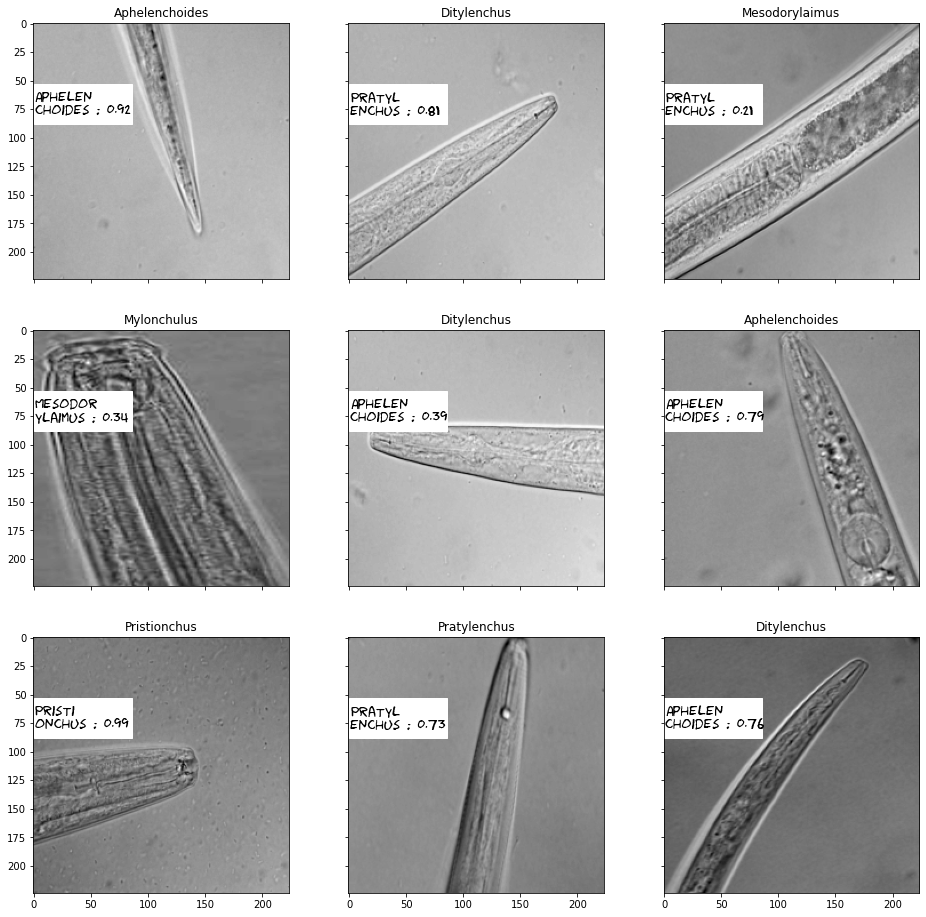

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(16, 16), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 500))
    im_val, label = valset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                valset.label_encoder.inverse_transform([label])[0].split("_")))



    imshow(im_val.data.cpu(), \
          title=img_label, plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53), 86, 35, color="white"))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + "\n" + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.2f}".format(predicted_label, predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment="left", fontproperties=font,
                    verticalalignment="top", fontsize=14, color="black", fontweight="bold")

Попробуем найти те классы, которые модель не смогла распознать:

In [ ]:
val_images = [valset[id][0].unsqueeze(0) for id in range(len(valset))]
val_predictions = get_predicts(model, val_images)

y_pred_val = np.argmax(val_predictions, -1)
actual_labels = [valset[id][1] for id in range(len(valset))]
preds_class = [label_encoder.classes_[i] for i in y_pred_val]

val_mertics_report = pd.DataFrame(classification_report(actual_labels, y_pred_val, output_dict=True)).T
val_mertics_report.index = list(label_encoder.inverse_transform(np.arange(19))) + ["accuracy", "macro avg", "weighted avg"]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
val_mertics_report

,precision,recall,f1-score,support
Acrobeles,0.000000,0.000000,0.000000,18.000000
Acrobeloides,0.362500,0.630435,0.460317,46.000000
Amplimerlinius,0.000000,0.000000,0.000000,6.000000
Aphelenchoides,0.415094,0.758621,0.536585,87.000000
Aporcelaimus,0.000000,0.000000,0.000000,32.000000
Axonchium,0.264706,0.428571,0.327273,42.000000
Discolimus,0.428571,0.187500,0.260870,16.000000
Ditylenchus,0.847826,0.475610,0.609375,82.000000
Dorylaimus,0.000000,0.000000,0.000000,9.000000
Eudorylaimus,0.083333,0.045455,0.058824,22.000000


Красота!

### Weighted Random Sampler

Как можно сделать upsampling редких классов.

In [ ]:
from collections import Counter
from torch.utils.data.sampler import WeightedRandomSampler


class_numbers = Counter(train_val_labels)
samples_weight = torch.tensor([1 / class_numbers[i] for i in train_val_labels])

In [ ]:
sampler = WeightedRandomSampler(samples_weight.type("torch.DoubleTensor"), len(samples_weight))

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, sampler=sampler)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, sampler=sampler)

# И так далее и так далее...
# Просто теперь редкие классы будут появляться чаще

## Сохраняем модель

model(image) -> preds -> class

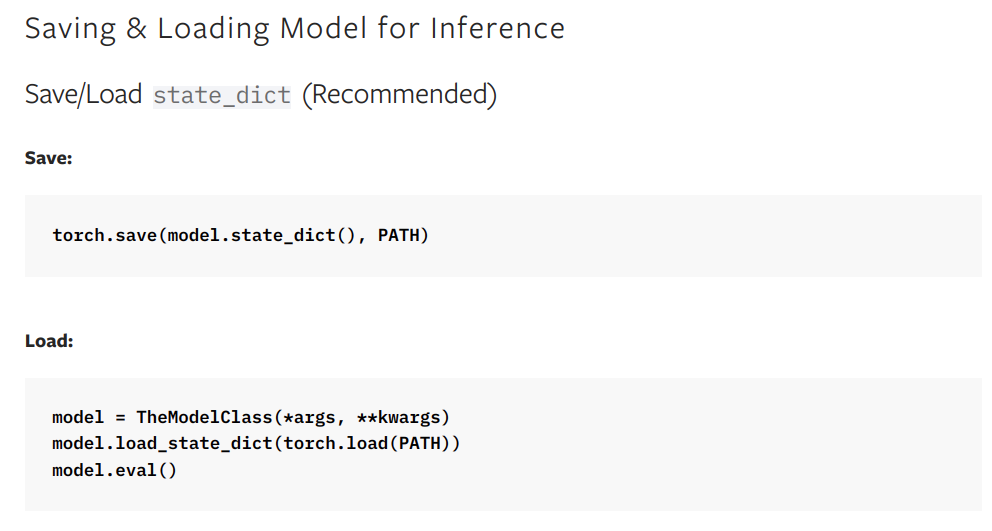